## Semantic Search using Sentence BERT/Sentence Transformers

### [CISI Dataset](https://www.kaggle.com/datasets/dmaso01dsta/cisi-a-dataset-for-information-retrieval)

### 1.Download and Import Libraries

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.2 MB/s 
     |████████████████████████████████| 4.7 MB 48.1 MB/s 
     |████████████████████████████████| 1.3 MB 59.2 MB/s 
     |████████████████████████████████| 120 kB 61.5 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=360b7fcf81d8ac8a1ab16a0b273062d088f33b436773486237110849010d9b56
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
import os
import pandas as pd
import numpy as np
#Libraries for sentence transformer
from sentence_transformers import SentenceTransformer, util
import torch
#Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

### 2.Load Dataset Files and Pretrained Sentence BERT <a id="load_data">

In [ ]:
def load_data():
    import os
    # upload files
    path = r"/content"

    #_____________ Read data from CISI.ALL file and store in dictinary ________________

    with open(os.path.join(path, 'CISI.ALL')) as f:
        lines = ""
        for l in f.readlines():
            # add new line char for lines starting with (.) and add space for other lines
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        #split a string into list based on newline(\n) separator.
        lines = lines.lstrip("\n").split("\n")

    # Put each DOCUMENT into a dictionary doc_set
    doc_set = {}
    doc_id = ""
    doc_text = ""

    for l in lines:
        if l.startswith(".I"):
            doc_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
        elif l.startswith(".X"):
            # indicate document ending
            doc_set[doc_id] = doc_text.lstrip(" ")
            doc_id = ""
            doc_text = ""
        else:
            # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
            doc_text += l.strip()[3:] + " "

    print(f"Number of documents = {len(doc_set)}")
    print(doc_set["1"]) # note that the dictionary indexes are strings, not numbers.


    #_____________ Read data from CISI.QRY file and store in dictinary ________________

    with open(os.path.join(path, 'CISI.QRY')) as f:
        lines = ""
        for l in f.readlines():
            lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
        lines = lines.lstrip("\n").split("\n")

    # Put each QUERY into a dictionary doc_set.
    qry_set = {}
    qry_id = ""
    for l in lines:
        if l.startswith(".I"):
            qry_id = l.split(" ")[1].strip() # l='.I 1' -> doc_id = 1
        elif l.startswith(".W"):
            # ignore first 3 characters of a line. l='.T 18 Editions..' -> doc_text = 19 Editions..
            qry_set[qry_id] = l.strip()[3:]
            qry_id = ""

    print(f"\n\nNumber of queries = {len(qry_set)}")
    print(qry_set["1"]) # note that the dictionary indexes are strings, not numbers.


    #_____________ Read data from CISI.REL file and store in dictinary ________________

    rel_set = {}
    with open(os.path.join(path, 'CISI.REL')) as f:
        for l in f.readlines():
            qry_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0] #split("\t")[0] -> '1     28'
            doc_id = l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1] #                 [0]   [-1]

            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)

    print(f"\n\nNumber of mappings = {len(rel_set)}")
    print(rel_set["1"]) # note that the dictionary indexes are strings, not numbers.

    return doc_set, qry_set, rel_set

In [ ]:
# returns dictionary with key->doc_id/query_id and value->data
doc_set, qry_set, rel_set = load_data()

Number of documents = 1460
18 Editions of the Dewey Decimal Classifications Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad. 


Number of queries = 112
What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


Number of mappings = 76
['28', '35', '38', '42', '43', '52', '65', '76', '86', '150', '189', '192', '193', '1

#### 2.1. Length of documents and Queries

In [ ]:
def get_length(doc_set, qry_set):
    # Length of documents
    min_d = 9999
    max_d = 0
    for i in doc_set:
        min_d = min(min_d, len(doc_set[i]))
        max_d = max(max_d, len(doc_set[i]))
    print(f"Doc length\n no. of characters min: {min_d}, max: {max_d}")

    # Length of queries
    min_q = 9999
    max_q = 0
    for i in qry_set:
        min_d = min(min_q, len(qry_set[i]))
        max_d = max(max_q, len(qry_set[i]))
    print(f"\nQuery length\n no. of characters min: {min_d}, max: {max_d}")

In [ ]:
get_length(doc_set, qry_set)

Doc length
 no. of characters min: 99, max: 3903

Query length
 no. of characters min: 432, max: 432


In [ ]:
#Load Sentence BERT model
pretrained_sbert = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

### 3.Data Modelling <a id='train_nn_system'>

#### 3.1. Compute embeddings for the corpus as well as query

In [ ]:
#compute the embeddings for the corpus
docs_embeddings = pretrained_sbert.encode(list(doc_set.values()), convert_to_tensor=True)

In [ ]:
docs_embeddings.shape

torch.Size([1460, 384])

In [ ]:
#compute the embeddings for the queries
query_embeddings = pretrained_sbert.encode(list(qry_set.values()), convert_to_tensor=True)

In [ ]:
'''By default,
query_chunk_size: process 100 queries simultaneously.
corpus_chunk_size: scans 100k entries in the corpus at a time.
score_function: cosine similarity for computing scores.
'''
#Returns list of Top 10 docs_id and scores for each query
top_k_scores = util.semantic_search(query_embeddings, docs_embeddings, top_k=10)

In [ ]:
top_k_scores[0] #   Top-10 docs for query-1

[{'corpus_id': 721, 'score': 0.644213080406189},
 {'corpus_id': 428, 'score': 0.6062507629394531},
 {'corpus_id': 588, 'score': 0.6023110747337341},
 {'corpus_id': 1280, 'score': 0.5792111158370972},
 {'corpus_id': 37, 'score': 0.5625131726264954},
 {'corpus_id': 649, 'score': 0.5565322041511536},
 {'corpus_id': 1194, 'score': 0.5528346300125122},
 {'corpus_id': 602, 'score': 0.5511060357093811},
 {'corpus_id': 782, 'score': 0.5296356678009033},
 {'corpus_id': 710, 'score': 0.5280510783195496}]

In [ ]:
#Get predicted TOP-10 doc_id for each query
predicted_doc_scores = {}

for i, query in enumerate(top_k_scores):
  predicted_doc_scores[str(i+1)] = []
  for doc_scores in query:
    predicted_doc_scores[str(i+1)].append(str(doc_scores['corpus_id']+1))

In [ ]:
predicted_doc_scores['1'] #TOP-10 predicted document ids of query-1

['722', '429', '589', '1281', '38', '650', '1195', '603', '783', '711']

### 4.Performance Metrics

#### 4.1 Recall@K [order-unaware]

In [ ]:
# Recall@K = TP/(TP+FN)
def recall_k(ground_truth, predictions, k):
  avg_recall = 0
  for query_id in ground_truth:
    truth_set = set(ground_truth[query_id]) #set doesn't maintain order of id's
    pred_set = set(predictions[query_id][:k])
    result = round(len(truth_set & pred_set) / float(len(truth_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    avg_recall += result
    #print(f"act_set: {len(truth_set)}, pred_set: {len(pred_set)}, &: {len(truth_set & pred_set)}")
  avg_recall /= len(ground_truth)

  return round(avg_recall, 3)

In [ ]:
print(f"Recall@5 = {recall_k(rel_set, predicted_doc_scores, 5)}") #Top-5 results
print(f"Recall@10 = {recall_k(rel_set, predicted_doc_scores, 10)}") #Top-10 results

Recall@5 = 0.079
Recall@10 = 0.124


#### 4.2 Precision@K [order-unaware]

In [ ]:
# Precision@K = TP/(TP+FP)
def precision_k(ground_truth, predictions, k):
  avg_precision = 0
  for query_id in ground_truth:
    truth_set = set(ground_truth[query_id]) #set doesn't maintain order of id's
    pred_set = set(predictions[query_id][:k])
    result = round(len(truth_set & pred_set) / float(len(pred_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
    avg_precision += result
    #print(f"act_set: {len(truth_set)}, pred_set: {len(pred_set)}, &: {len(truth_set & pred_set)}")
  avg_precision /= len(ground_truth)

  return round(avg_precision, 3)

In [ ]:
print(f"Precision@5 = {precision_k(rel_set, predicted_doc_scores, 5)}") #Top-5 results
print(f"Precision@10 = {precision_k(rel_set, predicted_doc_scores, 10)}") #Top-10 results

Precision@5 = 0.437
Precision@10 = 0.388


#### 4.3 Mean Reciprocal Rank (MRR) [order-aware]

In [ ]:
# first occurance of true positive i.e. index of first actual relevant docid predicted.
def get_first_relevent_docid(predictions, truth):
    for doc_id in predictions:
        is_exist = doc_id in truth #truth.count(doc_id)
        #print(f"predictions: {doc_id}, is_exist: {is_exist}")
        if is_exist:
            return predictions.index(doc_id)+1
    else:
        return -1

In [ ]:
def mrr(doc_scores, rel_set):
    Q = len(rel_set) # number of queries with known ground-truth
    cumulative_reciprocal = 0  # summation of reciprocals of the first actual relevant ranks

    for query_id in rel_set:
        # index of first actual relevant docid predicted
        first_result = get_first_relevent_docid(doc_scores[query_id], rel_set[query_id])
        # check if function returned index or -1 (for -1 use no. of docs+1 = 1461)
        first_result_rank = len(doc_scores['1'])+1 if first_result<1 else first_result
        reciprocal = 1 / first_result_rank
        cumulative_reciprocal += reciprocal
        #print(f"query #{query_id} = 1/{first_result} = {round(reciprocal,2)}")

    mrr = 1/Q * cumulative_reciprocal # mean of summation of cumulative_reciprocal
    return round(mrr,3)

In [ ]:
mrr = mrr(predicted_doc_scores, rel_set)
print(f"Mean Reciprocal Rank (MRR): {mrr}")

Mean Reciprocal Rank (MRR): 0.627


#### 4.4 Mean Average Precision (MAP) [order-aware]

In [ ]:
def map_k(rel_set, doc_scores, K):
    Q = len(rel_set) # number of queries with known ground-truth
    avg_precision = [] #AP of all queries

    for query_id in rel_set:
        precision_relevance_summation = 0

        for k in range(0,K):
            # calculate precision@k
            truth_set = set(rel_set[query_id])
            pred_set = set(doc_scores[query_id][:k+1])
            precision_at_k = round(len(truth_set & pred_set) / float(len(pred_set)), 2) # len(truth_set & pred_set)-> len(intersection of 2 sets)
            # check relevance of predicted docid at k
            rel_k = 1 if doc_scores[query_id][k] in rel_set[query_id] else 0
            precision_relevance_summation += precision_at_k * rel_k # summation of precision*relevance
            #print(f"qid: {query_id}, k: {k}, precision_at_k : {precision_at_k}, rel_k : {rel_k}, ap_num: {ap_num}, docid_sortedBy_score[query_id][k]: {docid_sortedBy_score[query_id][k]}")

        # AP value of query qid
        avg_precision_q = precision_relevance_summation / len(rel_set[query_id])
        #print(f"len(rel_set[q]): {len(rel_set[query_id])}, AP@{K}_{int(query_id)} = {round(avg_precision_q,2)}")
        avg_precision.append(avg_precision_q)

    map_k = sum(avg_precision) / Q # mean of all AP values of a query
    return round(map_k, 3)

In [ ]:
map_5 = map_k(rel_set, predicted_doc_scores, K=5)
print(f"MAP@5 = {map_5}")
map_10 = map_k(rel_set, predicted_doc_scores, K=10)
print(f"MAP@10 = {map_10}")

MAP@5 = 0.066
MAP@10 = 0.094


### 5.Performance Comparison of BM-25 vs MOV vs USE-DAN vs USE-Transformer vs SBERT
BM-25 vs Mean of vectors vs Universal Sentence Encoder using Deep Averaging Network (DAN) architecture vs Universal Sentence Encoder using Transformer architecture vs Sentence BERT

In [ ]:
data = {'model': ['BM-25', 'MOV', 'USE-DAN', 'USE-Transformer', 'SBERT'],
        'recall@10': [0.150, 0.035, 0.096, 0.092, 0.124],
        'precision@10': [0.700, 0.155, 0.274, 0.295, 0.388],
        'mrr': [0.620, 0.337, 0.555, 0.578, 0.627],
        'map@10': [0.100, 0.020, 0.051, 0.066, 0.094]
        }

df_performance = pd.DataFrame(data)
df_performance

,model,recall@10,precision@10,mrr,map@10
0,BM-25,0.150,0.700,0.620,0.100
1,MOV,0.035,0.155,0.337,0.020
2,USE-DAN,0.096,0.274,0.555,0.051
3,USE-Transformer,0.092,0.295,0.578,0.066
4,SBERT,0.124,0.388,0.627,0.094


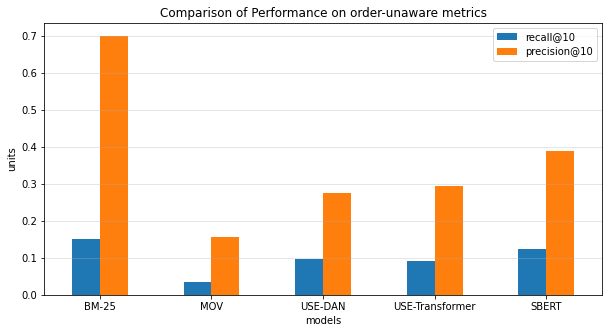

In [ ]:
df_performance[['model', 'recall@10', 'precision@10']].plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance on order-unaware metrics')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

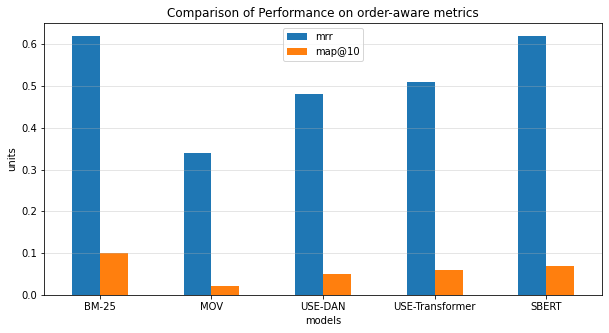

In [ ]:
df_performance[['model', 'mrr', 'map@10']].plot.bar(x='model', rot=0, figsize=(10,5))
plt.title('Comparison of Performance on order-aware metrics')
plt.xlabel('models')
plt.ylabel('units')
plt.grid(axis = 'y', alpha = 0.4)
plt.show()

#### Best Model: BM-25

Ordered as per order-aware metrics [MAP@10, MRR]: <br/>
***{ BM-25 -> SBERT -> USE-Transformer -> USE-DAN -> MOV }***